In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
import seaborn as sns
import pickle
import pandas as pd 
from scipy.interpolate import interp1d

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = 'white'
mpl.rcParams["axes.facecolor"] = 'white'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from statsmodels.tsa.stattools import grangercausalitytests

with open('data_behaviour.pkl', 'rb') as fp:
    data_behaviour = pickle.load(fp)


time_pre = 1
time_post = 1.5
nb_resample_points = 50
resample_time = np.linspace(-time_pre,time_post,nb_resample_points)

In [91]:
def format_data_psth(session_uid,plot_sessions=False,gain_change_sample=None):

    running_speed = data_behaviour[session_uid]['running_speed']
    running_speed[running_speed < -25] = None
    gain = data_behaviour[session_uid]['gain']
    trial_num = data_behaviour[session_uid]['trial_num']
    wheel_position = data_behaviour[session_uid]['wheel_position']
    df_over_f =data_behaviour[session_uid]['df_over_f']
    sample_times = data_behaviour[session_uid]['sample_times']
    absolute_speed = running_speed / gain

    if gain_change_sample == 'RL2_gain' :
        gain_change_samples = np.where(np.abs(np.diff(gain)) > 0.01)[0][:-1]
        print(gain_change_samples)
    elif gain_change_sample == 'RL2_phase' :
        gain_change_samples = np.where(np.abs(np.diff(wheel_position)) > 100)[0][:-1]
        print(gain_change_samples)
    else :
        gain_change_samples = np.where(np.diff(trial_num) > 0)[0]
    gain_change_magnitudes = [np.diff(gain)[ix] for ix in gain_change_samples]
    gain_pre = gain[gain_change_samples]
    gain_post = gain[gain_change_samples + 1]
    # print("number of gain change events",gain_pre.shape[0])
    trial_number = trial_num[gain_change_samples]
    sinusoid_frequency = 50 / 3  # from Romain
    delta_position = np.mod(np.diff(wheel_position)[gain_change_samples], sinusoid_frequency)
    glitch_limits = (sinusoid_frequency * 0.2, sinusoid_frequency * 0.8)

    dt = np.median(np.diff(sample_times))
    samples_pre = np.round(time_pre / dt).astype(int)
    samples_post = np.round(time_post / dt).astype(int)
    # print("sampling frequency",dt)

    gain_change_psth = []
    n_samples = len(df_over_f)

    # we need to rewrite this to resample the signal using interpolation.
    interp = interp1d(sample_times,df_over_f,fill_value="extrapolate")
    resample_df_over_f = interp(resample_time)


    for sample in gain_change_samples:
        trial_trace = df_over_f[(sample - samples_pre) : (sample + samples_post)]
        if sample + samples_post - n_samples > 0:
            trial_trace = np.concatenate(
                (trial_trace, np.full(sample + samples_post - n_samples, np.nan))
            )
        trial_time = np.linspace(-time_pre,time_post,samples_pre+samples_post)
        interp = interp1d(trial_time,trial_trace,fill_value="extrapolate")
        resample_df_over_f = interp(resample_time)
        gain_change_psth.append(resample_df_over_f[:, np.newaxis])
        

    gain_change_psth =  np.concatenate(gain_change_psth, axis=1).T
    # print(gain_change_psth.shape)
    gain_change_df = pd.DataFrame(gain_change_psth)
    gain_change_df["gain_change_magnitude"] = gain_change_magnitudes
    gain_change_df["phase_shift"] = delta_position
    gain_change_df["gain_pre"] = gain_pre
    gain_change_df["gain_post"] = gain_post
    gain_change_df['trial_number'] = trial_number
    gain_change_df = gain_change_df.melt(
                    id_vars=[
                    "gain_change_magnitude",
                    "phase_shift",
                    "gain_pre",
                    "gain_post",
                    "trial_number"]).rename(columns={"variable": "time", "value": "dF/F"})
    gain_change_df['phase_shift_approx'] = "other"
    gain_change_df.loc[
        (gain_change_df["phase_shift"] <= glitch_limits[0])
        | (gain_change_df["phase_shift"] >= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to 0"
    gain_change_df.loc[
        (gain_change_df["phase_shift"] >= glitch_limits[0])
        & (gain_change_df["phase_shift"] <= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to pi"

    gain_change_psth_speed = []
    for sample in gain_change_samples:
        trial_trace = absolute_speed[(sample - samples_pre) : (sample + samples_post)]
        if sample + samples_post - n_samples > 0:
            padded_trace = np.concatenate(
                (trial_trace, np.full(sample + samples_post - n_samples, np.nan))
            )
        trial_time = np.linspace(-time_pre,time_post,samples_pre+samples_post)
        interp = interp1d(trial_time,trial_trace,fill_value="extrapolate")
        resample_df_over_f = interp(resample_time)
        gain_change_psth_speed.append(resample_df_over_f[:, np.newaxis])

    gain_change_psth_speed =  np.concatenate(gain_change_psth_speed, axis=1).T
    gain_change_df_speed = pd.DataFrame(gain_change_psth_speed)
    gain_change_df_speed["gain_change_magnitude"] = gain_change_magnitudes
    gain_change_df_speed["phase_shift"] = delta_position
    gain_change_df_speed["gain_pre"] = gain_pre
    gain_change_df_speed["gain_post"] = gain_post
    gain_change_df_speed['trial_number'] = trial_number
    gain_change_df_speed = gain_change_df_speed.melt(
                    id_vars=[
                    "gain_change_magnitude",
                    "phase_shift",
                    "gain_pre",
                    "gain_post",
                    "trial_number"]).rename(columns={"variable": "time", "value": "speed"})
    gain_change_df_speed['phase_shift_approx'] = "other"
    gain_change_df_speed.loc[
        (gain_change_df_speed["phase_shift"] <= glitch_limits[0])
        | (gain_change_df_speed["phase_shift"] >= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to 0"
    gain_change_df_speed.loc[
        (gain_change_df_speed["phase_shift"] >= glitch_limits[0])
        & (gain_change_df_speed["phase_shift"] <= glitch_limits[1]),
        "phase_shift_approx",
    ] = "Close to pi"

    print(session_uid + " : "+ str(scipy.stats.spearmanr(df_over_f[~np.isnan(absolute_speed)],absolute_speed[~np.isnan(absolute_speed)])))


    #perform Granger-Causality test
    df_causality_test = pd.DataFrame({"df_over_f" : df_over_f[~np.isnan(absolute_speed)] , "speed": absolute_speed[~np.isnan(absolute_speed)]  }) 
    grangercausalitytests(df_causality_test[['df_over_f', 'speed']], maxlag=[10])
    grangercausalitytests(df_causality_test[['speed', 'df_over_f']], maxlag=[10])
    if plot_sessions : 

        sigma_smooth = 50
        i_start=0
        i_end= 100000
        true_time = sample_times[~np.isnan(absolute_speed)][i_start:i_end]
        f = plt.figure(figsize=(20,10))
        trial_changes = np.where(np.diff(trial_num[~np.isnan(running_speed)][i_start:i_end]) > 0)[0]
        '''
        plt.subplot(611)
        plt.plot(running_speed[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('running speed')
        plt.subplot(612)
        plt.plot(gain[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('gain')
        plt.subplot(613)
        plt.plot(trial_num[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('trial_num')
        plt.subplot(614)
        plt.plot(wheel_position[~np.isnan(running_speed)][i_start:i_end])
        plt.ylabel('wheel_position')
        '''
        plt.subplot(311)
        plt.plot(true_time,scipy.ndimage.gaussian_filter1d(df_over_f[~np.isnan(absolute_speed)][i_start:i_end],sigma=sigma_smooth))
        plt.vlines(x=true_time[trial_changes],ymin=df_over_f.min(),ymax=df_over_f.max(),color='r',ls='--')
        plt.xlabel("time (s)")
        plt.ylabel('df_over_f',fontsize=10)

        plt.subplot(312)
        plt.plot(true_time,scipy.ndimage.gaussian_filter1d(absolute_speed[~np.isnan(absolute_speed)][i_start:i_end],sigma=sigma_smooth))
        plt.vlines(x=true_time[trial_changes],ymin=absolute_speed[~np.isnan(absolute_speed)].min(),ymax=absolute_speed[~np.isnan(absolute_speed)].max(),color='r',ls='--')
        plt.xlabel("time (s)")
        plt.ylabel('absolute speed')
        
        plt.subplot(313)
        plt.plot(true_time,gain[~np.isnan(absolute_speed)][i_start:i_end],color='k')
        plt.xlabel("time (s)")
        plt.ylabel('gain')

        f.suptitle(session_uid + str(scipy.stats.spearmanr(df_over_f[~np.isnan(absolute_speed)],absolute_speed[~np.isnan(absolute_speed)])))
        f.tight_layout()
        plt.show()
        
        


    gain_change_df['uid'] = session_uid
    gain_change_df['speed'] = gain_change_df_speed['speed']

    return gain_change_df

In [92]:
sessions_uid = list(data_behaviour.keys())
sessions_uid.remove('RL1_3_3')
sessions_uid.remove('RL2_1_0')
sessions_uid.remove('RL2_5_0') # bad

RL1_1_0 : SpearmanrResult(correlation=-0.11937484161930381, pvalue=1.440153199261473e-297)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=26.8076 , p=0.0000  , df_denom=94680, df_num=10
ssr based chi2 test:   chi2=268.1357, p=0.0000  , df=10
likelihood ratio test: chi2=267.7568, p=0.0000  , df=10
parameter F test:         F=26.8076 , p=0.0000  , df_denom=94680, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.6243  , p=0.0000  , df_denom=94680, df_num=10
ssr based chi2 test:   chi2=86.2621 , p=0.0000  , df=10
likelihood ratio test: chi2=86.2228 , p=0.0000  , df=10
parameter F test:         F=8.6243  , p=0.0000  , df_denom=94680, df_num=10


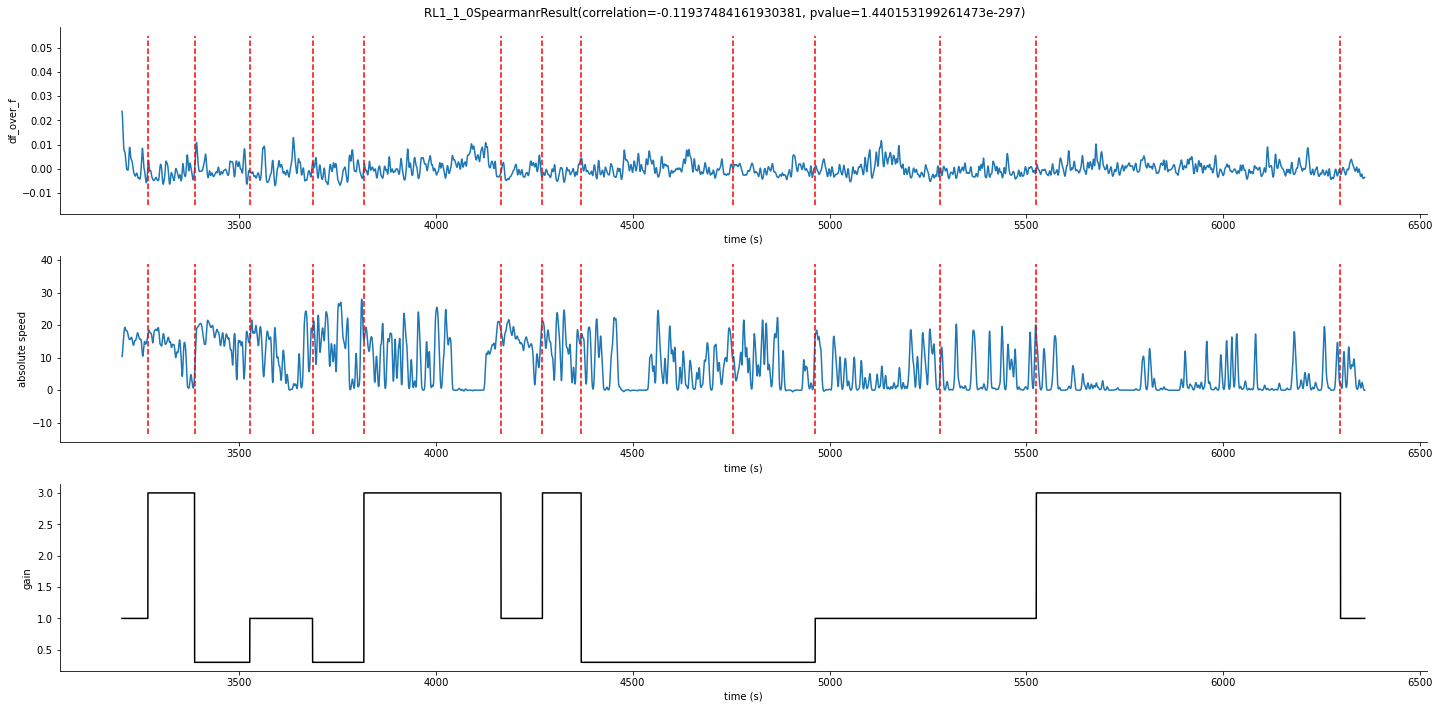

RL1_1_1 : SpearmanrResult(correlation=-0.23965940613261977, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=25.6629 , p=0.0000  , df_denom=99628, df_num=10
ssr based chi2 test:   chi2=256.6827, p=0.0000  , df=10
likelihood ratio test: chi2=256.3527, p=0.0000  , df=10
parameter F test:         F=25.6629 , p=0.0000  , df_denom=99628, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.0212  , p=0.0000  , df_denom=99628, df_num=10
ssr based chi2 test:   chi2=80.2290 , p=0.0000  , df=10
likelihood ratio test: chi2=80.1967 , p=0.0000  , df=10
parameter F test:         F=8.0212  , p=0.0000  , df_denom=99628, df_num=10


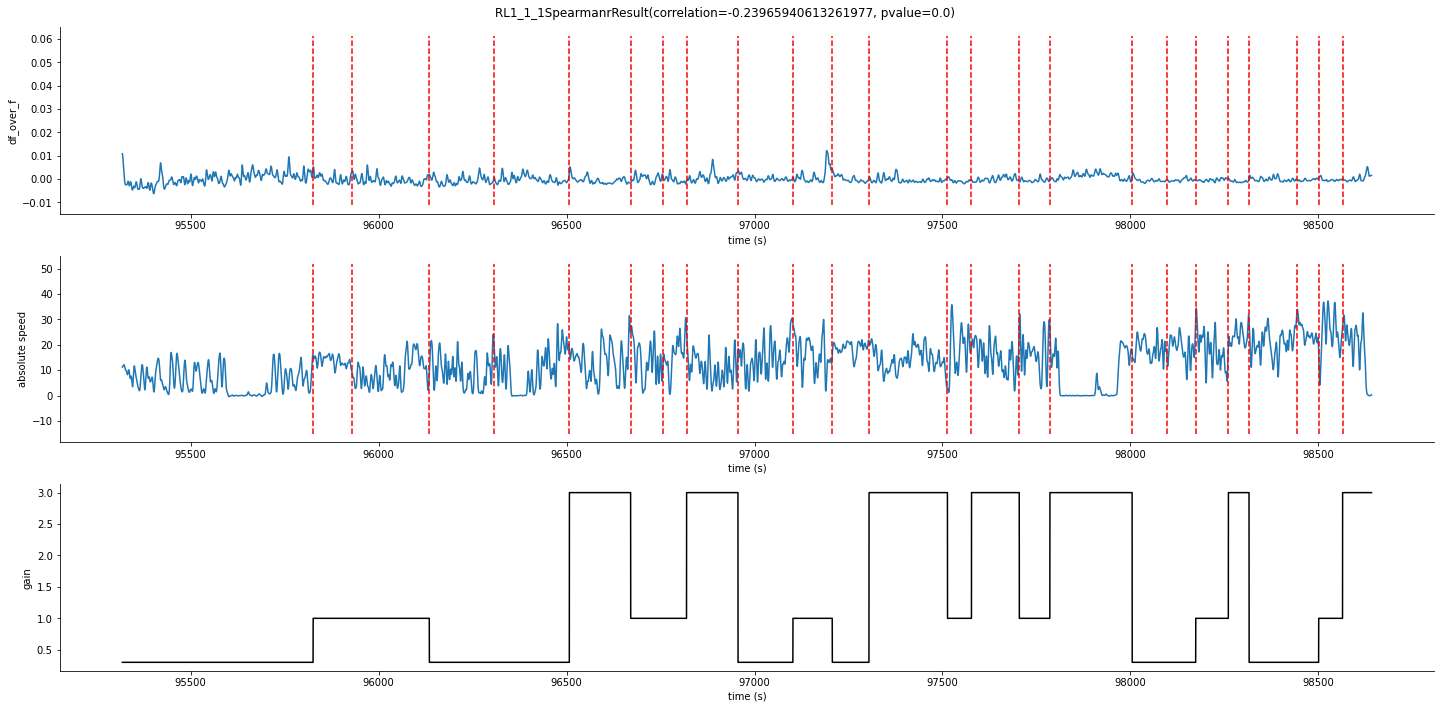

RL1_1_2 : SpearmanrResult(correlation=-0.24605623688923298, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=25.5822 , p=0.0000  , df_denom=99715, df_num=10
ssr based chi2 test:   chi2=255.8755, p=0.0000  , df=10
likelihood ratio test: chi2=255.5479, p=0.0000  , df=10
parameter F test:         F=25.5822 , p=0.0000  , df_denom=99715, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=28.5568 , p=0.0000  , df_denom=99715, df_num=10
ssr based chi2 test:   chi2=285.6282, p=0.0000  , df=10
likelihood ratio test: chi2=285.2200, p=0.0000  , df=10
parameter F test:         F=28.5568 , p=0.0000  , df_denom=99715, df_num=10


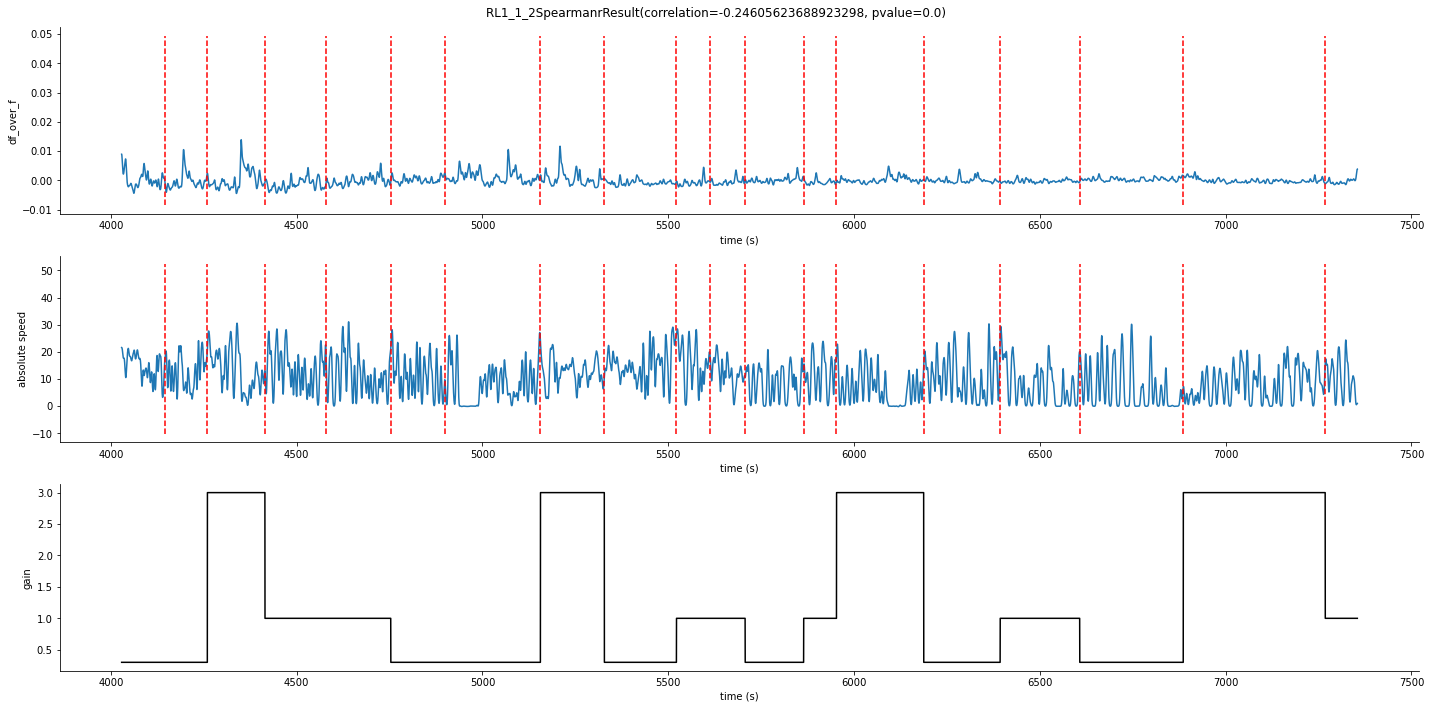

RL1_1_3 : SpearmanrResult(correlation=-0.2420410955648059, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=12.9079 , p=0.0000  , df_denom=45856, df_num=10
ssr based chi2 test:   chi2=129.1381, p=0.0000  , df=10
likelihood ratio test: chi2=128.9567, p=0.0000  , df=10
parameter F test:         F=12.9079 , p=0.0000  , df_denom=45856, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.6312 , p=0.0000  , df_denom=45856, df_num=10
ssr based chi2 test:   chi2=116.3648, p=0.0000  , df=10
likelihood ratio test: chi2=116.2175, p=0.0000  , df=10
parameter F test:         F=11.6312 , p=0.0000  , df_denom=45856, df_num=10


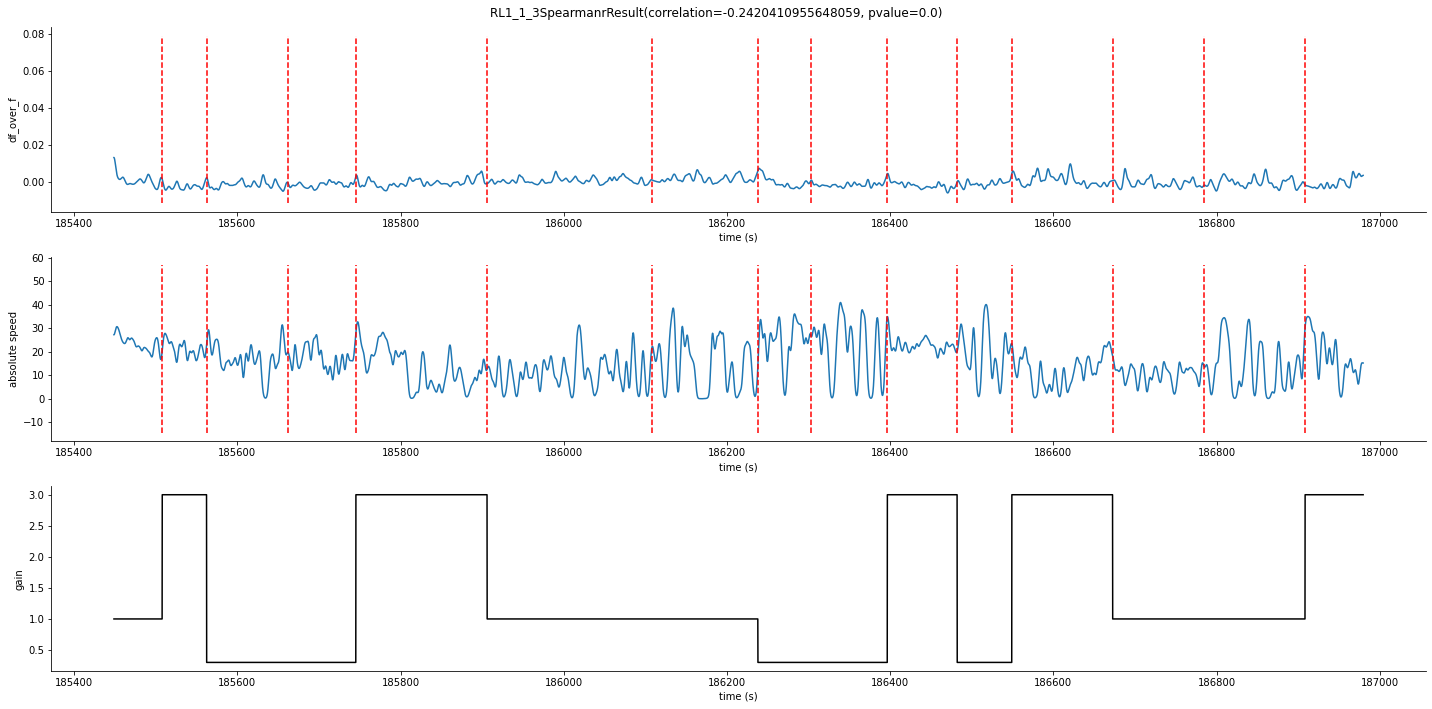

RL1_1_4 : SpearmanrResult(correlation=-0.4174716126584676, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=49.8776 , p=0.0000  , df_denom=65548, df_num=10
ssr based chi2 test:   chi2=498.9354, p=0.0000  , df=10
likelihood ratio test: chi2=497.0466, p=0.0000  , df=10
parameter F test:         F=49.8776 , p=0.0000  , df_denom=65548, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=15.2805 , p=0.0000  , df_denom=65548, df_num=10
ssr based chi2 test:   chi2=152.8541, p=0.0000  , df=10
likelihood ratio test: chi2=152.6763, p=0.0000  , df=10
parameter F test:         F=15.2805 , p=0.0000  , df_denom=65548, df_num=10


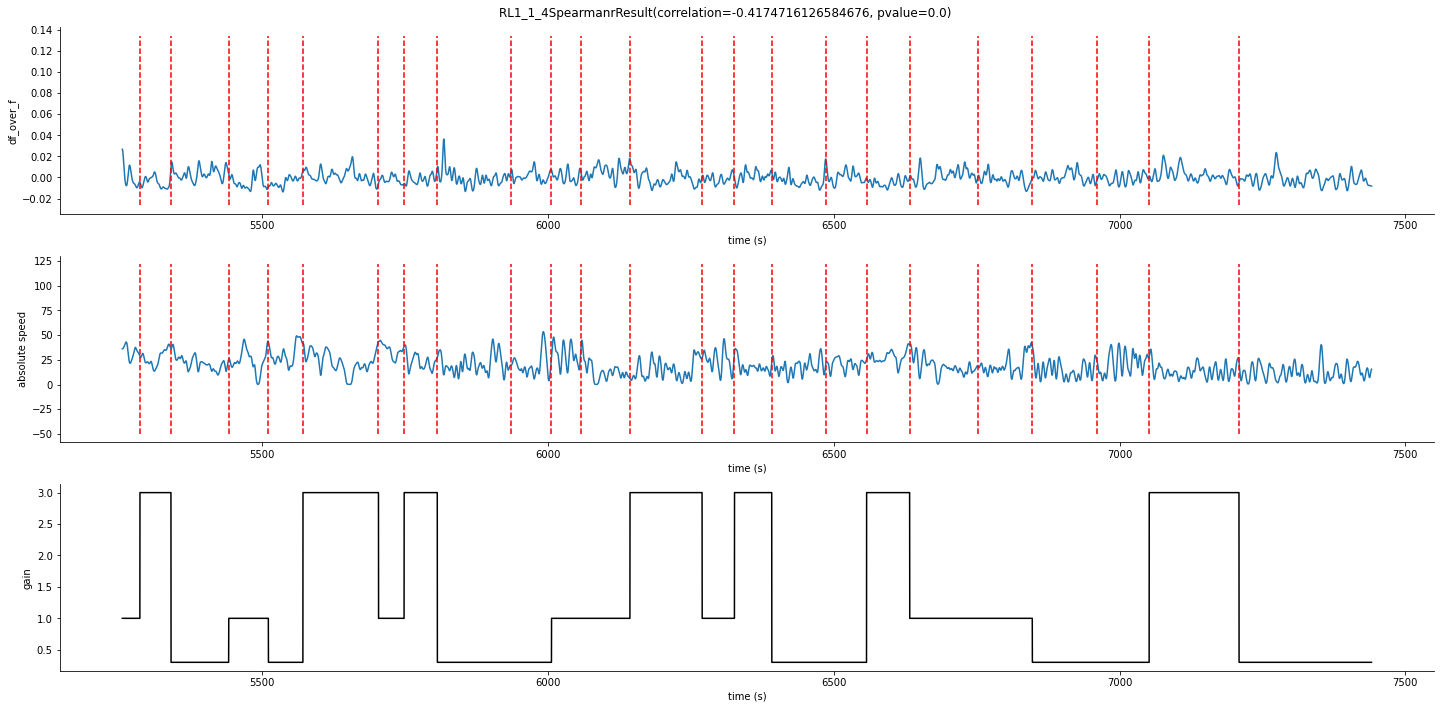

RL1_2_0 : SpearmanrResult(correlation=-0.28142593148154493, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=13.2719 , p=0.0000  , df_denom=51299, df_num=10
ssr based chi2 test:   chi2=132.7729, p=0.0000  , df=10
likelihood ratio test: chi2=132.6015, p=0.0000  , df=10
parameter F test:         F=13.2719 , p=0.0000  , df_denom=51299, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=18.5994 , p=0.0000  , df_denom=51299, df_num=10
ssr based chi2 test:   chi2=186.0703, p=0.0000  , df=10
likelihood ratio test: chi2=185.7338, p=0.0000  , df=10
parameter F test:         F=18.5994 , p=0.0000  , df_denom=51299, df_num=10


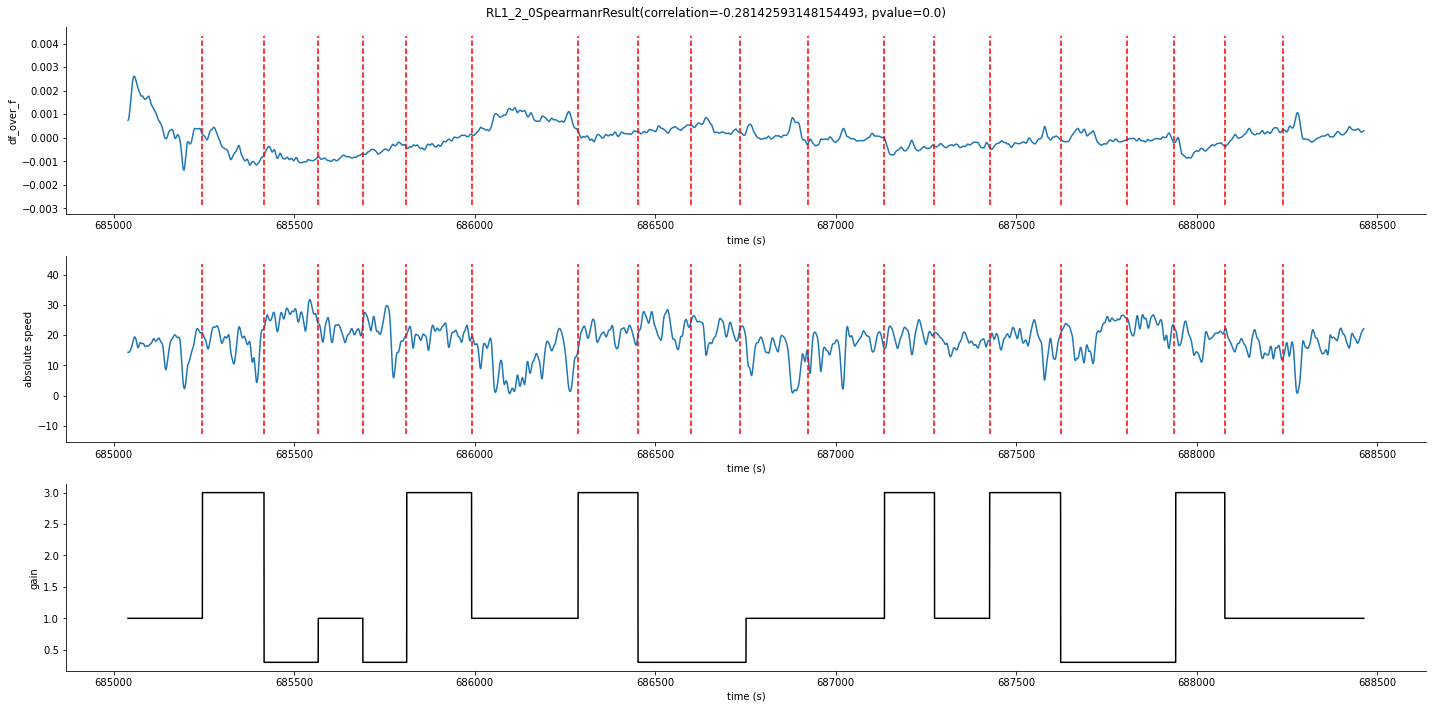

RL1_2_1 : SpearmanrResult(correlation=-0.0070940395164822544, pvalue=0.1637541038818715)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6606  , p=0.0836  , df_denom=38504, df_num=10
ssr based chi2 test:   chi2=16.6152 , p=0.0833  , df=10
likelihood ratio test: chi2=16.6116 , p=0.0834  , df=10
parameter F test:         F=1.6606  , p=0.0836  , df_denom=38504, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5301  , p=0.0048  , df_denom=38504, df_num=10
ssr based chi2 test:   chi2=25.3149 , p=0.0048  , df=10
likelihood ratio test: chi2=25.3066 , p=0.0048  , df=10
parameter F test:         F=2.5301  , p=0.0048  , df_denom=38504, df_num=10


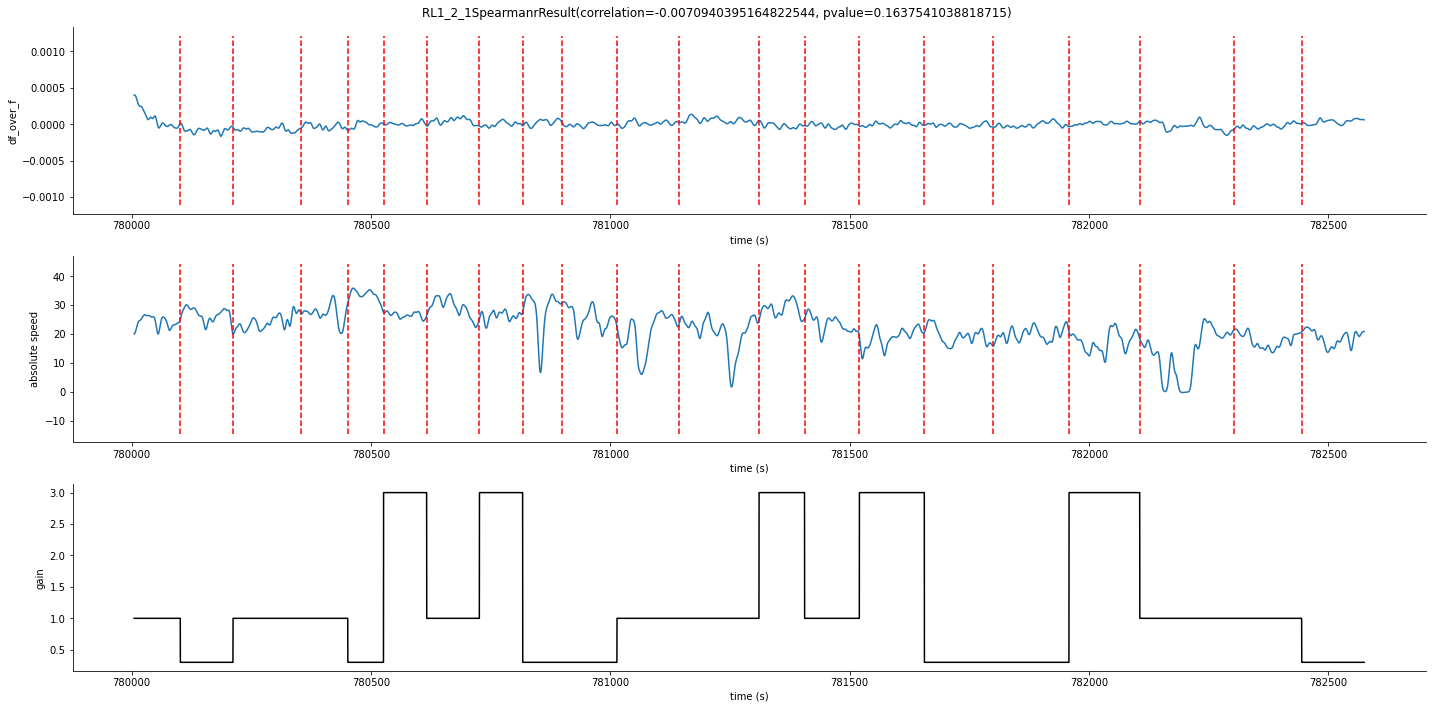

RL1_2_2 : SpearmanrResult(correlation=-0.04148808115353754, pvalue=1.0420751860282256e-12)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8565  , p=0.0000  , df_denom=29438, df_num=10
ssr based chi2 test:   chi2=38.5923 , p=0.0000  , df=10
likelihood ratio test: chi2=38.5670 , p=0.0000  , df=10
parameter F test:         F=3.8565  , p=0.0000  , df_denom=29438, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2823  , p=0.2338  , df_denom=29438, df_num=10
ssr based chi2 test:   chi2=12.8318 , p=0.2332  , df=10
likelihood ratio test: chi2=12.8290 , p=0.2334  , df=10
parameter F test:         F=1.2823  , p=0.2338  , df_denom=29438, df_num=10


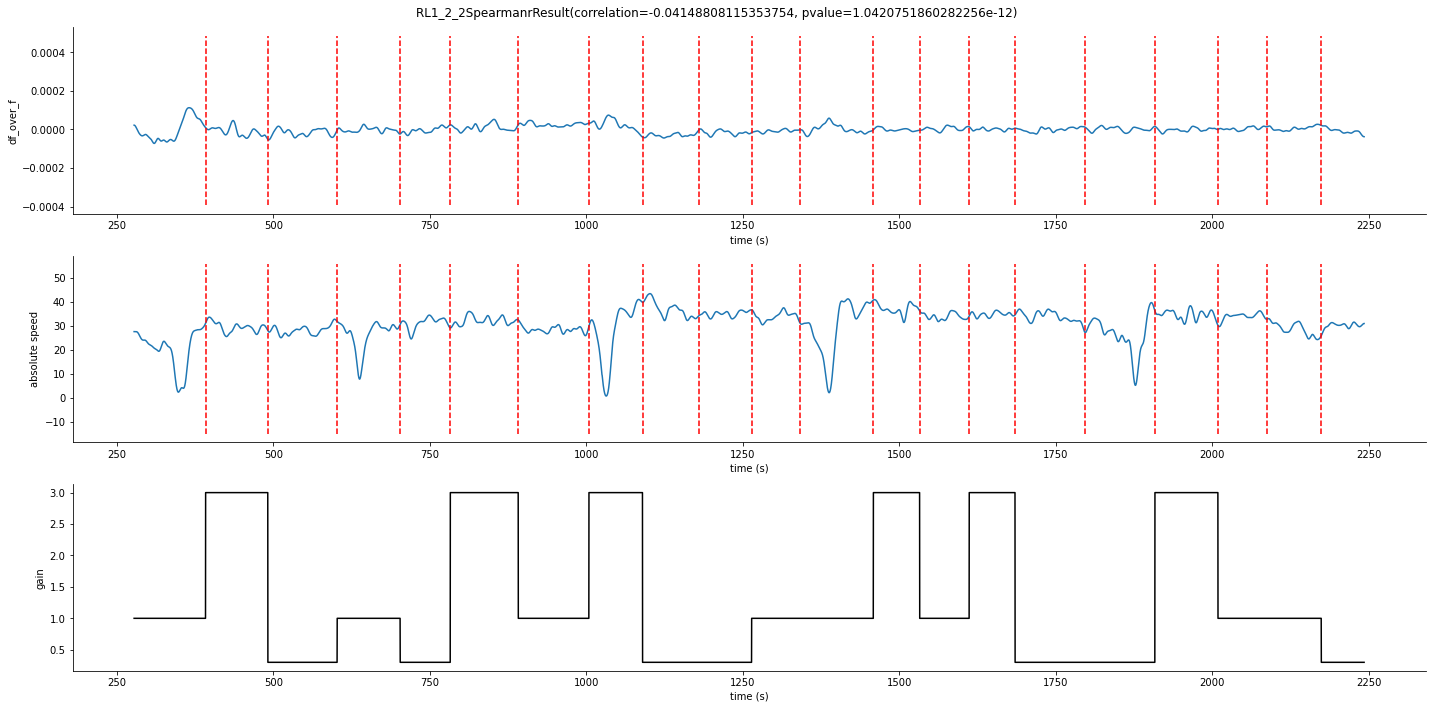

RL1_3_0 : SpearmanrResult(correlation=-0.07014106825177387, pvalue=1.129277374476863e-84)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=37.6112 , p=0.0000  , df_denom=77060, df_num=10
ssr based chi2 test:   chi2=376.2147, p=0.0000  , df=10
likelihood ratio test: chi2=375.2995, p=0.0000  , df=10
parameter F test:         F=37.6112 , p=0.0000  , df_denom=77060, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=68.6527 , p=0.0000  , df_denom=77060, df_num=10
ssr based chi2 test:   chi2=686.7142, p=0.0000  , df=10
likelihood ratio test: chi2=683.6733, p=0.0000  , df=10
parameter F test:         F=68.6527 , p=0.0000  , df_denom=77060, df_num=10


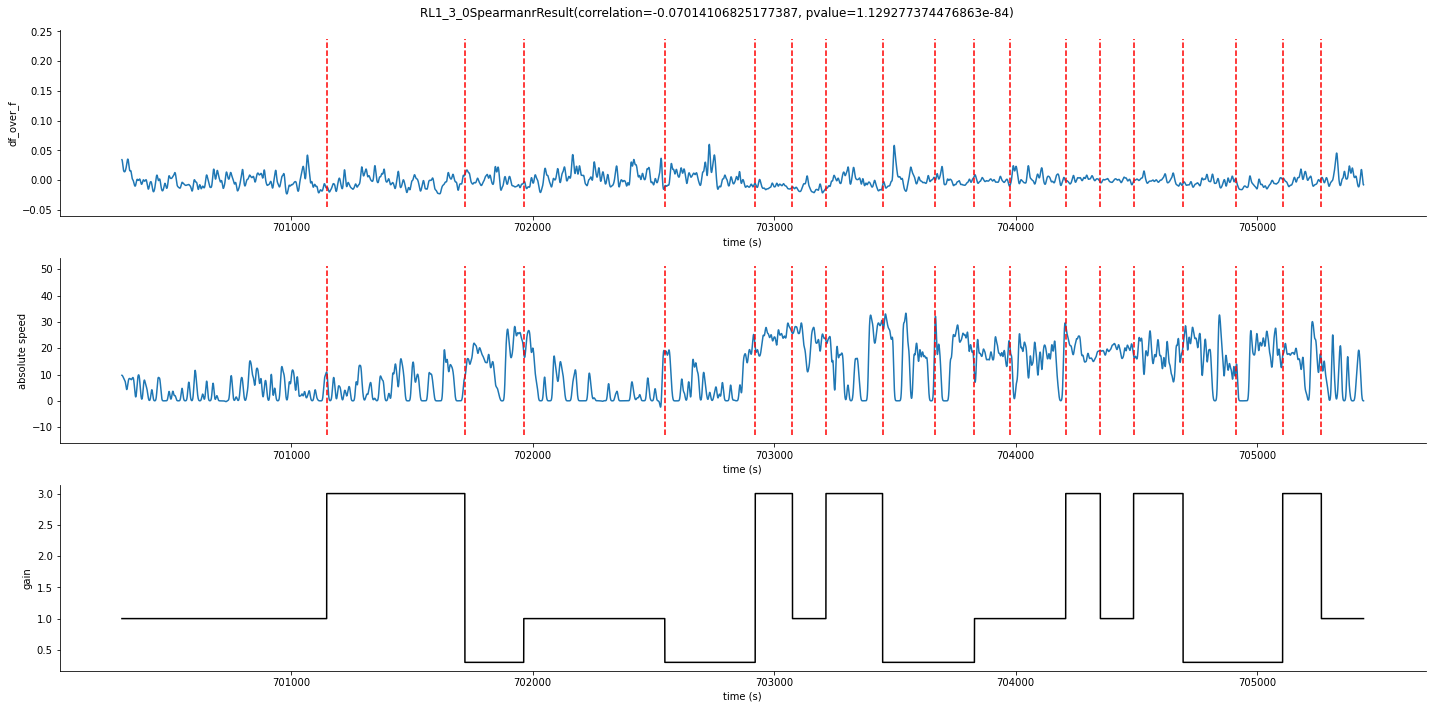

RL1_3_1 : SpearmanrResult(correlation=-0.2611736565237219, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=36.3565 , p=0.0000  , df_denom=42753, df_num=10
ssr based chi2 test:   chi2=363.7431, p=0.0000  , df=10
likelihood ratio test: chi2=362.2052, p=0.0000  , df=10
parameter F test:         F=36.3565 , p=0.0000  , df_denom=42753, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=53.7641 , p=0.0000  , df_denom=42753, df_num=10
ssr based chi2 test:   chi2=537.9054, p=0.0000  , df=10
likelihood ratio test: chi2=534.5513, p=0.0000  , df=10
parameter F test:         F=53.7641 , p=0.0000  , df_denom=42753, df_num=10


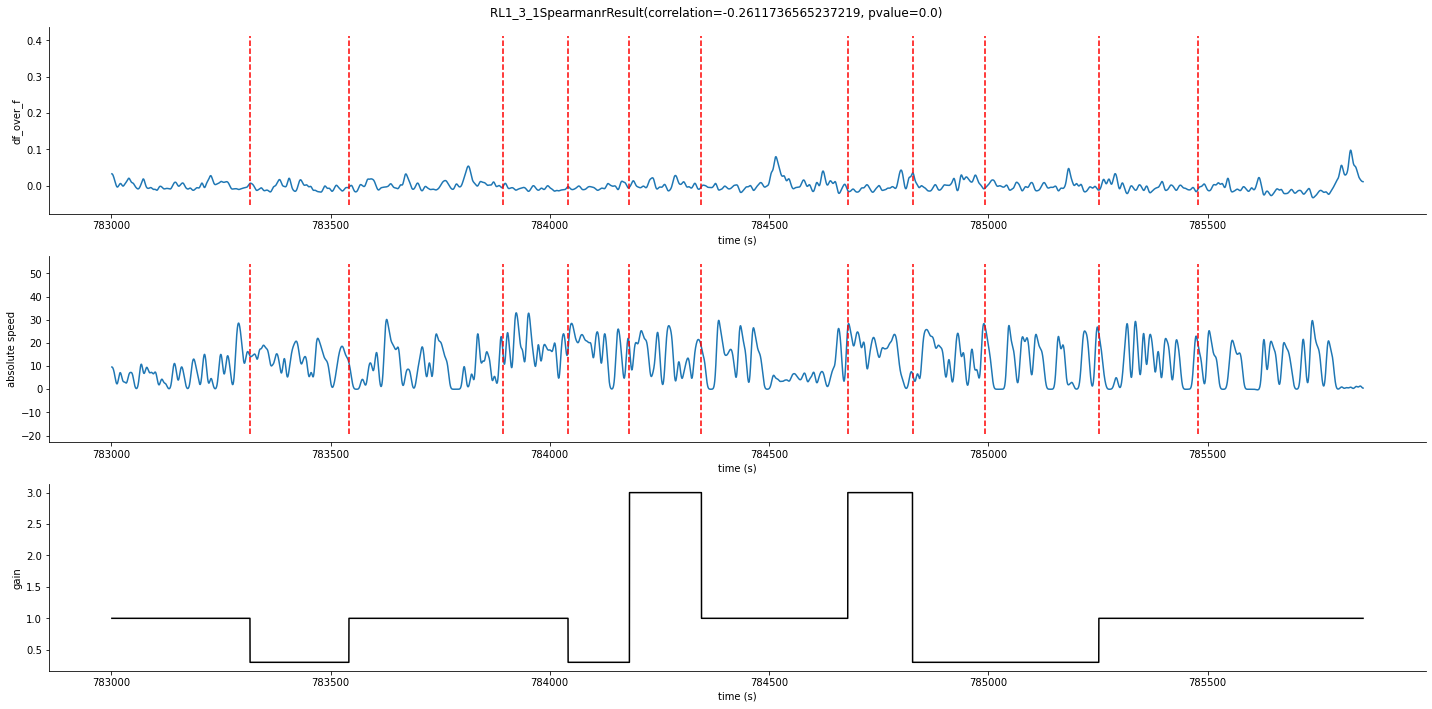

RL1_3_2 : SpearmanrResult(correlation=-0.34046087702775873, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=34.9292 , p=0.0000  , df_denom=65635, df_num=10
ssr based chi2 test:   chi2=349.4035, p=0.0000  , df=10
likelihood ratio test: chi2=348.4771, p=0.0000  , df=10
parameter F test:         F=34.9292 , p=0.0000  , df_denom=65635, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=66.0047 , p=0.0000  , df_denom=65635, df_num=10
ssr based chi2 test:   chi2=660.2581, p=0.0000  , df=10
likelihood ratio test: chi2=656.9603, p=0.0000  , df=10
parameter F test:         F=66.0047 , p=0.0000  , df_denom=65635, df_num=10


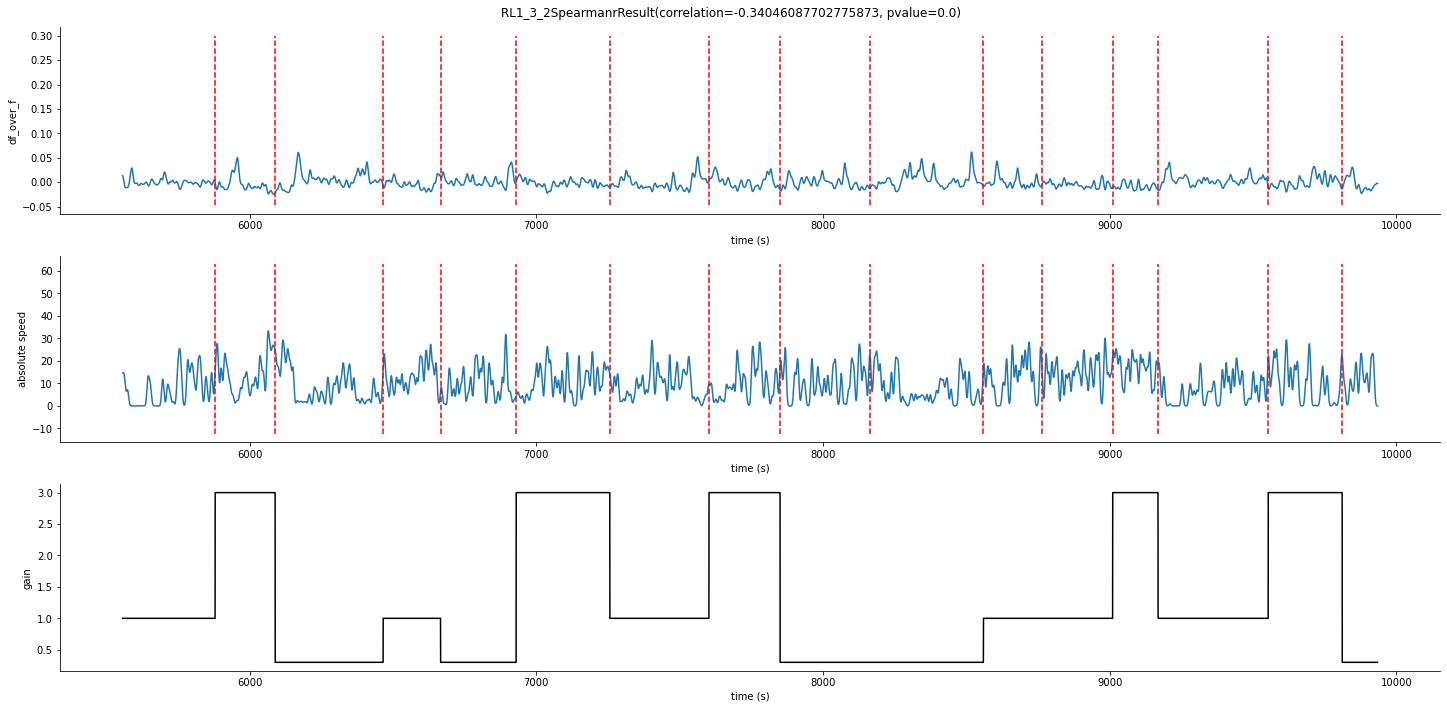

RL1_4_0 : SpearmanrResult(correlation=0.1581395677822626, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=9.5145  , p=0.0000  , df_denom=81775, df_num=10
ssr based chi2 test:   chi2=95.1699 , p=0.0000  , df=10
likelihood ratio test: chi2=95.1146 , p=0.0000  , df=10
parameter F test:         F=9.5145  , p=0.0000  , df_denom=81775, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.7226  , p=0.0000  , df_denom=81775, df_num=10
ssr based chi2 test:   chi2=77.2463 , p=0.0000  , df=10
likelihood ratio test: chi2=77.2098 , p=0.0000  , df=10
parameter F test:         F=7.7226  , p=0.0000  , df_denom=81775, df_num=10


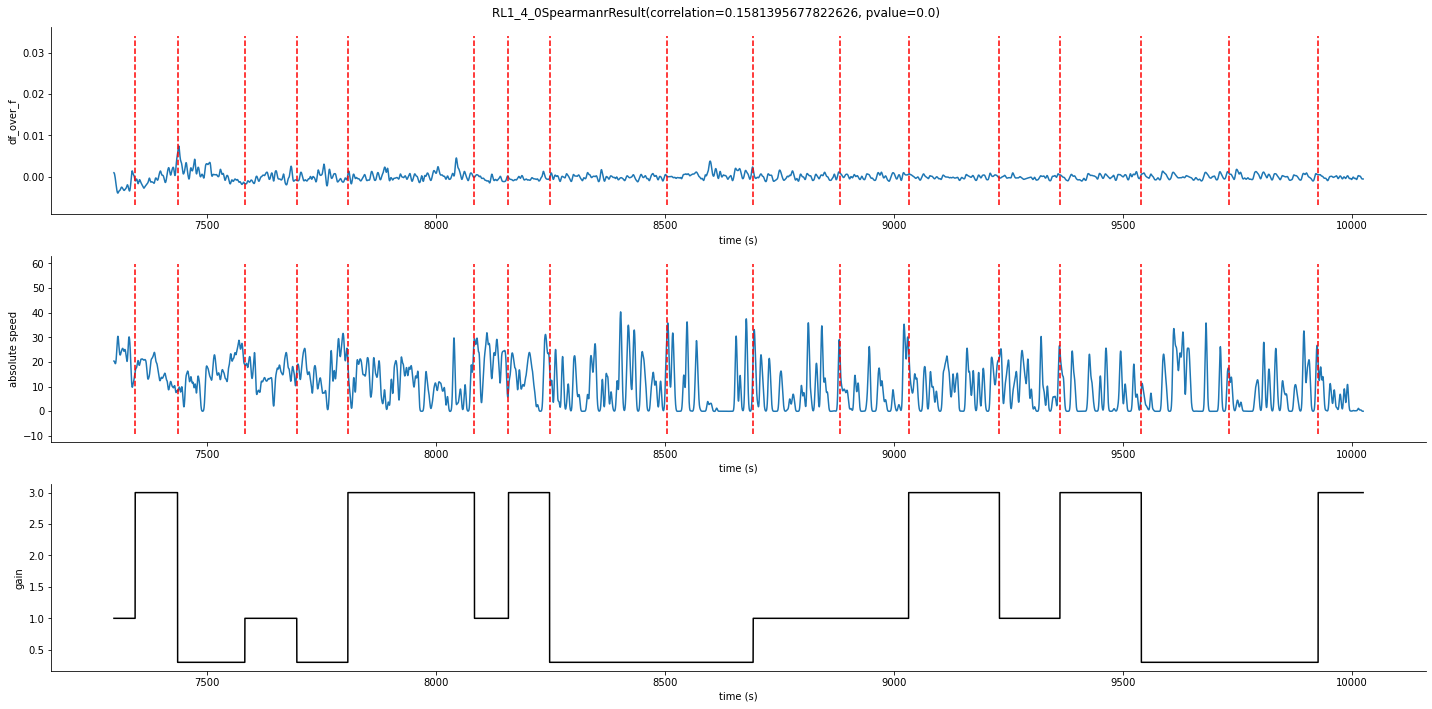

RL1_4_1 : SpearmanrResult(correlation=0.4509256546093682, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6338  , p=0.0000  , df_denom=74648, df_num=10
ssr based chi2 test:   chi2=46.3507 , p=0.0000  , df=10
likelihood ratio test: chi2=46.3364 , p=0.0000  , df=10
parameter F test:         F=4.6338  , p=0.0000  , df_denom=74648, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=39.9169 , p=0.0000  , df_denom=74648, df_num=10
ssr based chi2 test:   chi2=399.2808, p=0.0000  , df=10
likelihood ratio test: chi2=398.2170, p=0.0000  , df=10
parameter F test:         F=39.9169 , p=0.0000  , df_denom=74648, df_num=10


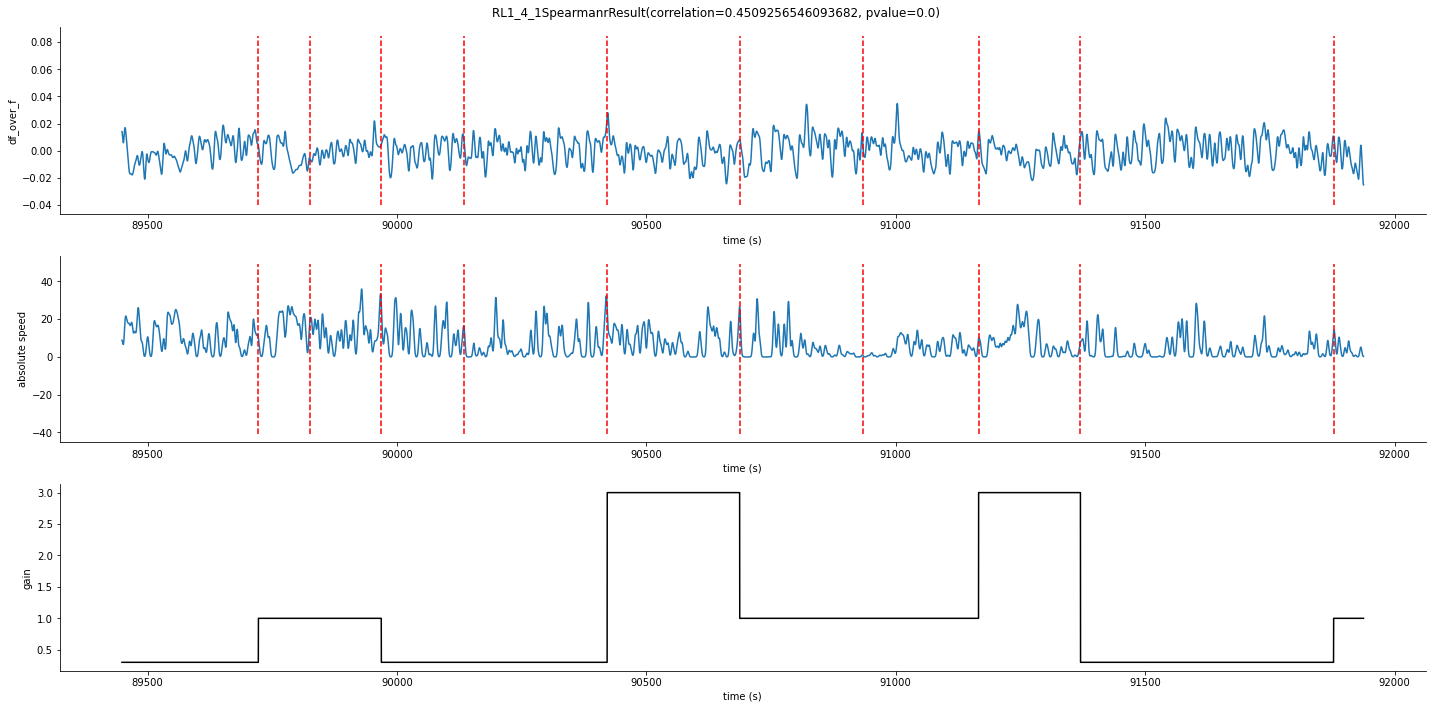

RL1_4_2 : SpearmanrResult(correlation=0.31590063943381064, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=9.0159  , p=0.0000  , df_denom=73798, df_num=10
ssr based chi2 test:   chi2=90.1846 , p=0.0000  , df=10
likelihood ratio test: chi2=90.1295 , p=0.0000  , df=10
parameter F test:         F=9.0159  , p=0.0000  , df_denom=73798, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=16.4001 , p=0.0000  , df_denom=73798, df_num=10
ssr based chi2 test:   chi2=164.0481, p=0.0000  , df=10
likelihood ratio test: chi2=163.8661, p=0.0000  , df=10
parameter F test:         F=16.4001 , p=0.0000  , df_denom=73798, df_num=10


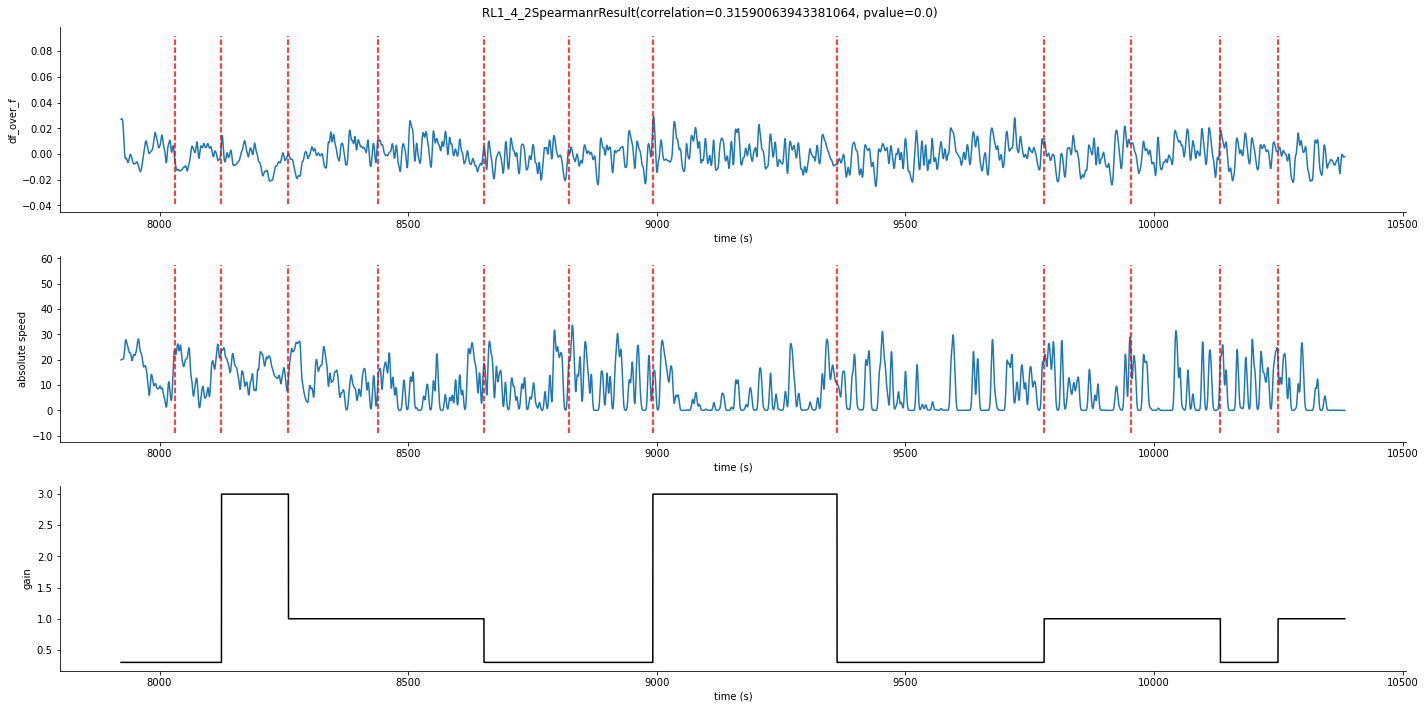

RL1_5_0 : SpearmanrResult(correlation=-0.2995904027556628, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=30.0166 , p=0.0000  , df_denom=55235, df_num=10
ssr based chi2 test:   chi2=300.2800, p=0.0000  , df=10
likelihood ratio test: chi2=299.4670, p=0.0000  , df=10
parameter F test:         F=30.0166 , p=0.0000  , df_denom=55235, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=23.5368 , p=0.0000  , df_denom=55235, df_num=10
ssr based chi2 test:   chi2=235.4579, p=0.0000  , df=10
likelihood ratio test: chi2=234.9576, p=0.0000  , df=10
parameter F test:         F=23.5368 , p=0.0000  , df_denom=55235, df_num=10


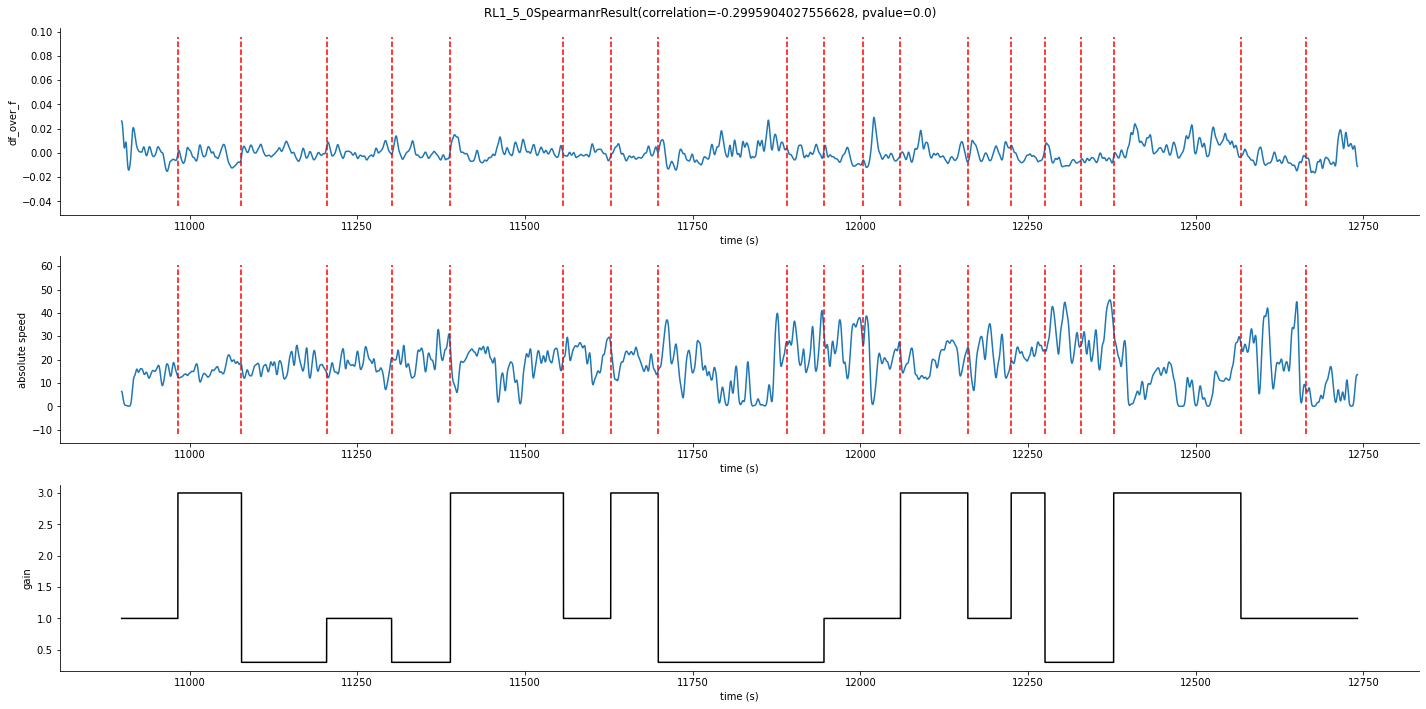

RL1_5_1 : SpearmanrResult(correlation=-0.293644392083839, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=27.7137 , p=0.0000  , df_denom=83724, df_num=10
ssr based chi2 test:   chi2=277.2064, p=0.0000  , df=10
likelihood ratio test: chi2=276.7486, p=0.0000  , df=10
parameter F test:         F=27.7137 , p=0.0000  , df_denom=83724, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=11.1519 , p=0.0000  , df_denom=83724, df_num=10
ssr based chi2 test:   chi2=111.5473, p=0.0000  , df=10
likelihood ratio test: chi2=111.4730, p=0.0000  , df=10
parameter F test:         F=11.1519 , p=0.0000  , df_denom=83724, df_num=10


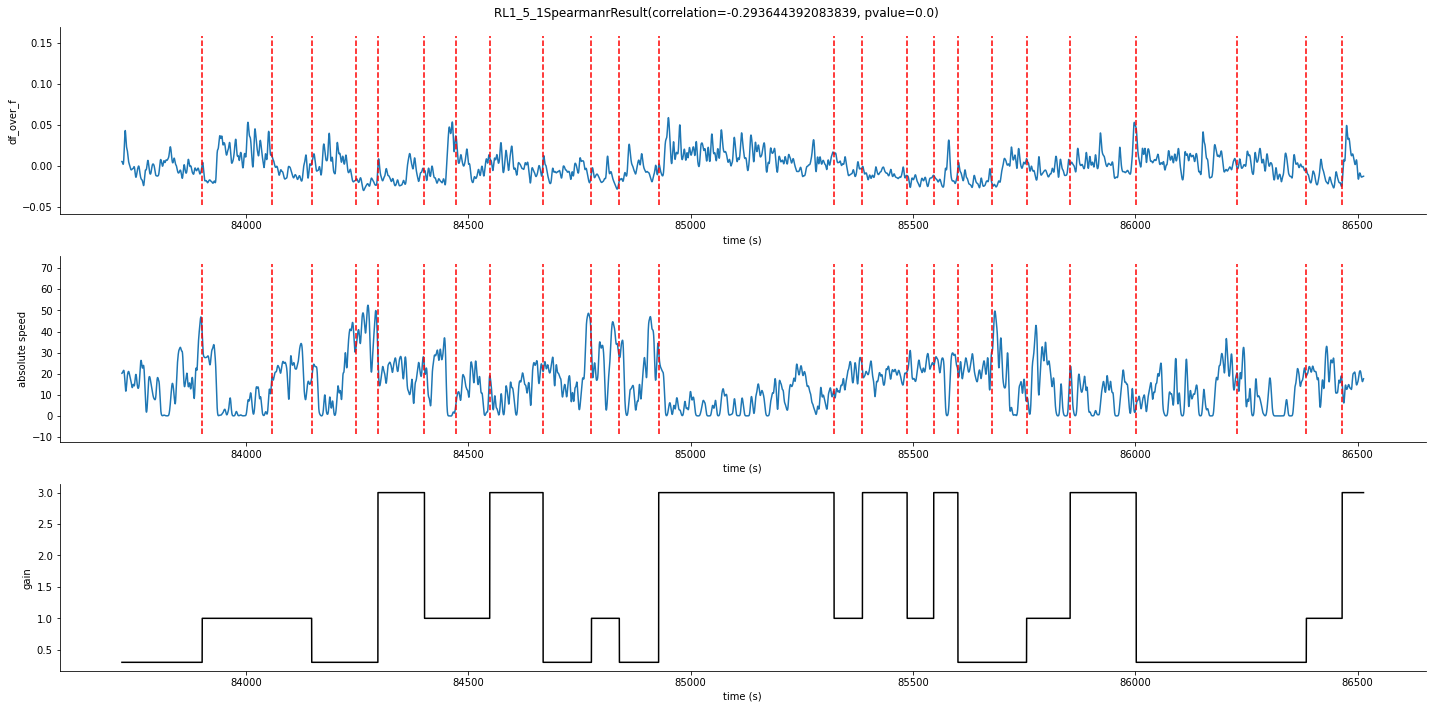

RL1_5_2 : SpearmanrResult(correlation=-0.23343202671049393, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=28.9013 , p=0.0000  , df_denom=96380, df_num=10
ssr based chi2 test:   chi2=289.0765, p=0.0000  , df=10
likelihood ratio test: chi2=288.6439, p=0.0000  , df=10
parameter F test:         F=28.9013 , p=0.0000  , df_denom=96380, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=45.2801 , p=0.0000  , df_denom=96380, df_num=10
ssr based chi2 test:   chi2=452.9001, p=0.0000  , df=10
likelihood ratio test: chi2=451.8395, p=0.0000  , df=10
parameter F test:         F=45.2801 , p=0.0000  , df_denom=96380, df_num=10


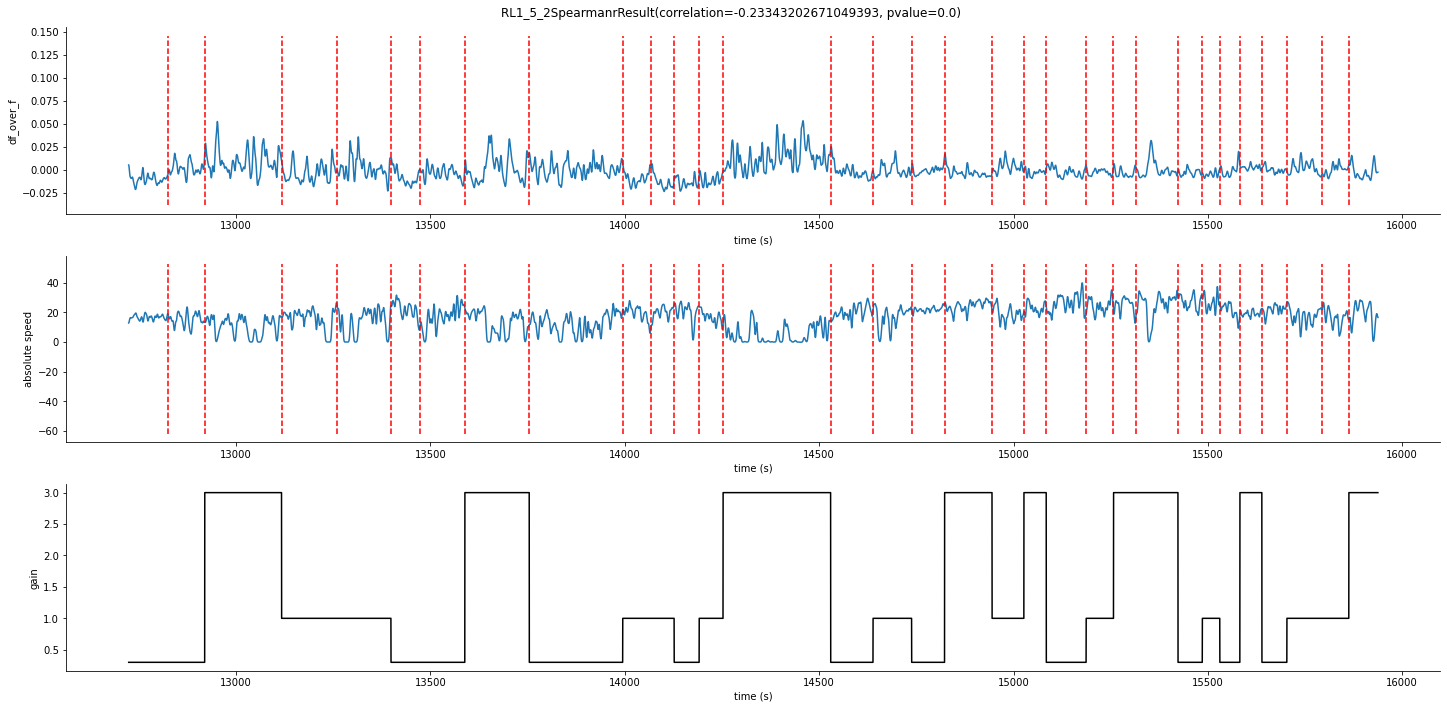

RL1_5_3 : SpearmanrResult(correlation=-0.5000602191993679, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=28.9045 , p=0.0000  , df_denom=80036, df_num=10
ssr based chi2 test:   chi2=289.1207, p=0.0000  , df=10
likelihood ratio test: chi2=288.5999, p=0.0000  , df=10
parameter F test:         F=28.9045 , p=0.0000  , df_denom=80036, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=92.7572 , p=0.0000  , df_denom=80036, df_num=10
ssr based chi2 test:   chi2=927.8158, p=0.0000  , df=10
likelihood ratio test: chi2=922.4806, p=0.0000  , df=10
parameter F test:         F=92.7572 , p=0.0000  , df_denom=80036, df_num=10


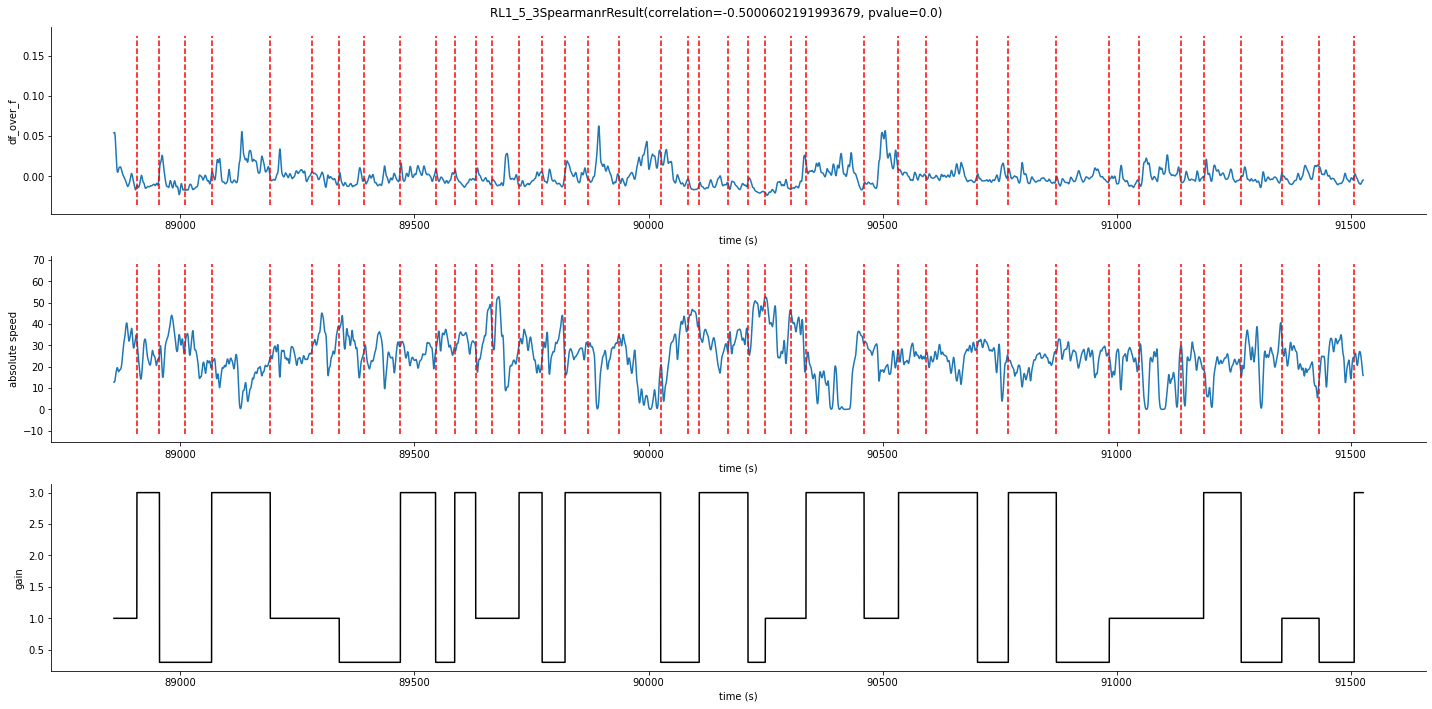

RL1_5_4 : SpearmanrResult(correlation=0.18618908016072094, pvalue=0.0)

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=23.0046 , p=0.0000  , df_denom=106964, df_num=10
ssr based chi2 test:   chi2=230.0910, p=0.0000  , df=10
likelihood ratio test: chi2=229.8439, p=0.0000  , df=10
parameter F test:         F=23.0046 , p=0.0000  , df_denom=106964, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=31.0046 , p=0.0000  , df_denom=106964, df_num=10
ssr based chi2 test:   chi2=310.1069, p=0.0000  , df=10
likelihood ratio test: chi2=309.6584, p=0.0000  , df=10
parameter F test:         F=31.0046 , p=0.0000  , df_denom=106964, df_num=10


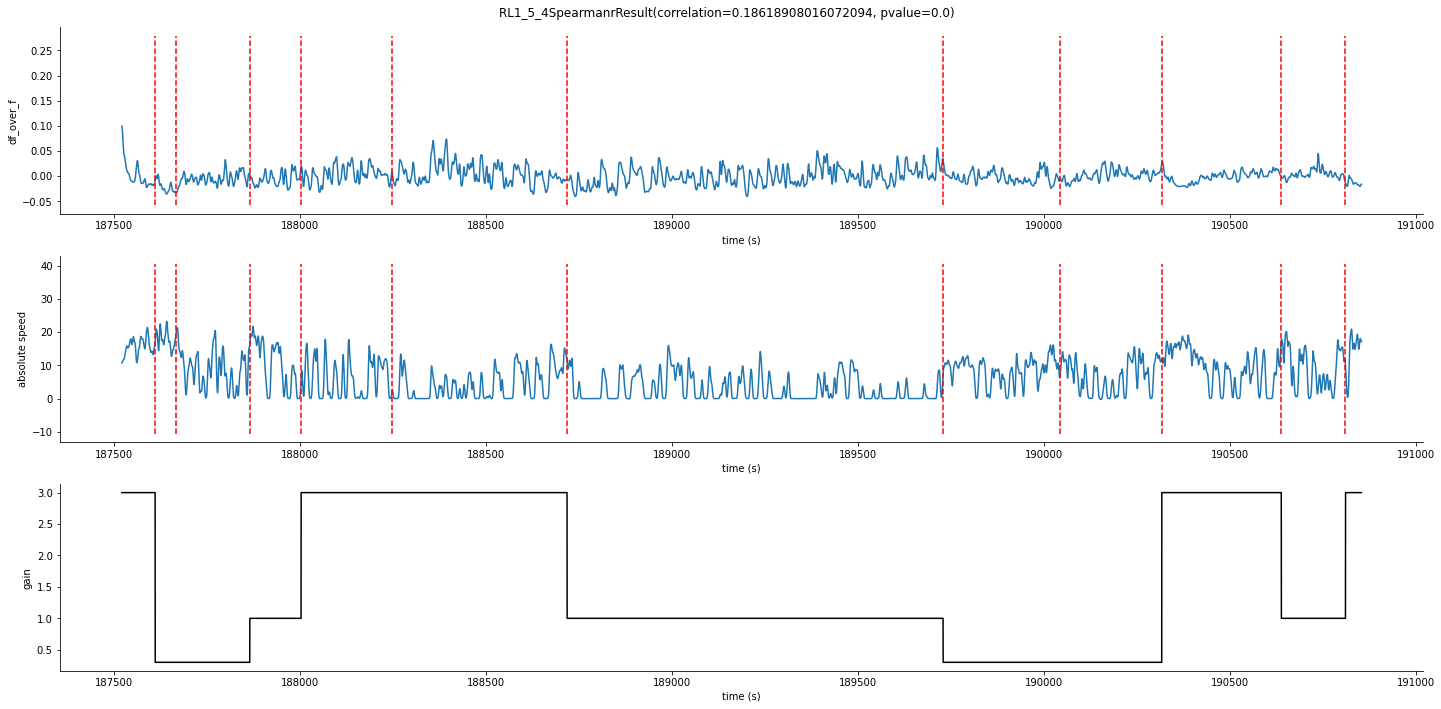

In [93]:
list_df_data = []
for uid in sessions_uid :
    # print(uid)
    gain_change_df = format_data_psth(uid,plot_sessions=True)
    list_df_data.append(gain_change_df)
gain_change_df = pd.concat(list_df_data)

gain_change_df = gain_change_df.dropna()
dict_map_mag = {-2.7 : "--", -2 : '-',-0.7:'-',0:'0',0.7 : '+',2.7 : "++", 2 : '+'}
gain_change_df['gain_change'] = gain_change_df['gain_change_magnitude'] 
gain_change_df = gain_change_df.replace({"gain_change_magnitude": dict_map_mag})

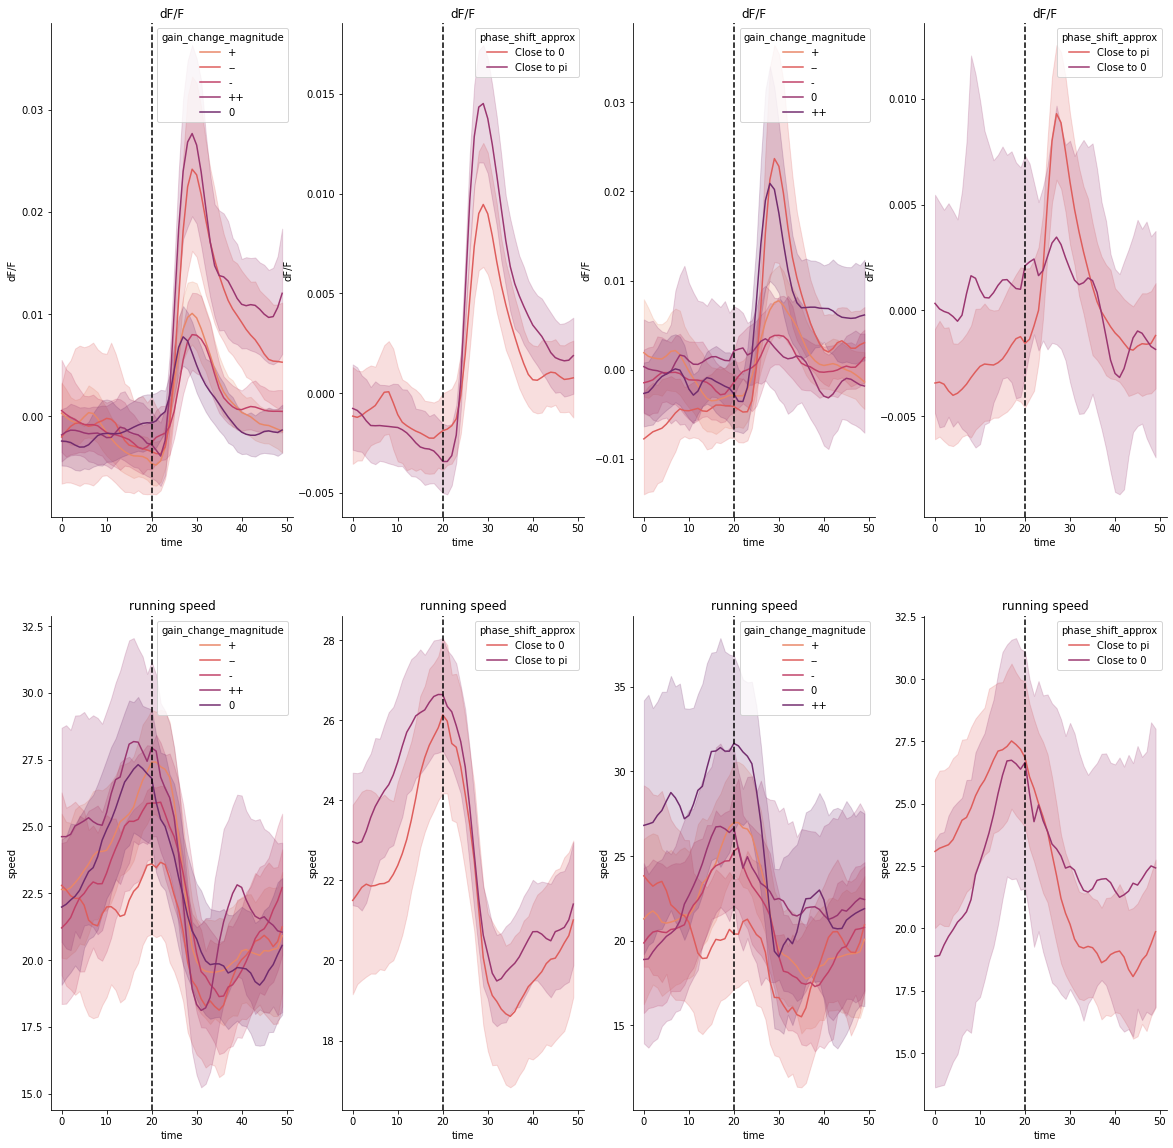

In [57]:
plt.figure(figsize=(20,20))


p_norm = 0.05

plt.subplot(241)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

'''
p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(['--','++']))]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(["0"]))]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")
'''


plt.subplot(242)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='phase_shift_approx',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')
'''
p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to 0")]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to pi")]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")
'''
plt.subplot(243)
sns.lineplot(
    data=gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"],
    x="time",
    y="dF/F",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

'''
p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"][(gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"]['time'] == i) & (gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"]['gain_change_magnitude'].isin(['--','++']))]['dF/F'].values
    b = gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"][(gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"]['time'] == i) & (gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"]['gain_change_magnitude'].isin(["0"]))]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")

'''

plt.subplot(244)
sns.lineplot(
    data=gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])],
    x="time",
    y="dF/F",
    hue='phase_shift_approx',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')
'''
p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])][(gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])]['time'] == i) & (gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])]['phase_shift_approx'] == "Close to 0")]['dF/F'].values
    b = gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])][(gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])]['time'] == i) & (gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])]['phase_shift_approx'] == "Close to pi")]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)
print(p_val)
p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")
'''

plt.subplot(245)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.subplot(246)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='phase_shift_approx',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.subplot(247)
sns.lineplot(
    data=gain_change_df[gain_change_df['phase_shift_approx'] == "Close to 0"],
    x="time",
    y="speed",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.subplot(248)
sns.lineplot(
    data=gain_change_df[gain_change_df['gain_change_magnitude'].isin(["0"])],
    x="time",
    y="speed",
    hue='phase_shift_approx',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.show()

### Relationship between serotonin transient and speed

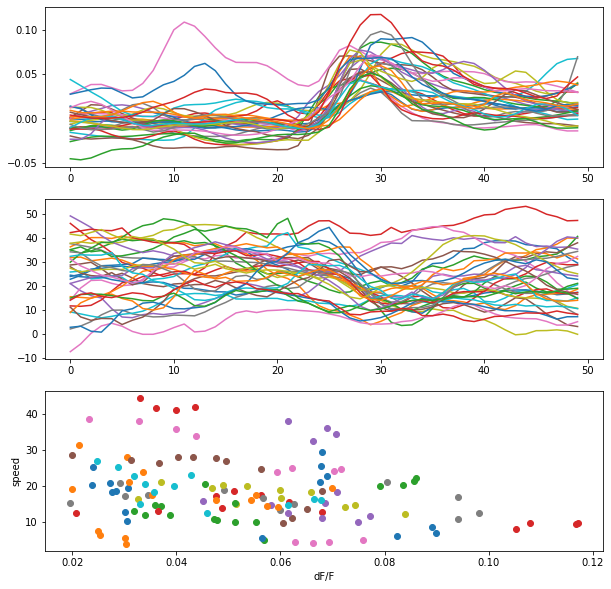

In [277]:
f,axs = plt.subplots(3,1,figsize=(10,10))
gain_change_df_1 = gain_change_df.copy()
gain_change_df_1 = gain_change_df_1[gain_change_df_1['gain_change_magnitude'].isin(['--','++'])]
for uid in gain_change_df_1["uid"].unique():
    for trial_number in gain_change_df_1[(gain_change_df_1["uid"] == uid)]["trial_number"].unique():
        df = gain_change_df_1[(gain_change_df_1["uid"] == uid) & (gain_change_df_1["trial_number"] == trial_number)]
        if df['dF/F'].values[30] > 0.03:
            axs[0].plot(df['time'].values,df['dF/F'].values)
            axs[1].plot(df['time'].values,df['speed'].values)
            axs[2].scatter(df['dF/F'].values[28:32],df['speed'].values[28:32])
plt.xlabel('dF/F')
plt.ylabel('speed')
plt.show()

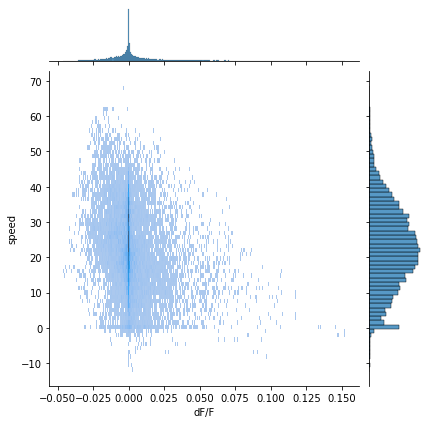

In [68]:
sns.jointplot(x=gain_change_df["dF/F"], y=gain_change_df["speed"],kind="hist")

In [71]:
from statsmodels.tsa.stattools import grangercausalitytests

#perform Granger-Causality test
grangercausalitytests(gain_change_df[['dF/F', 'speed']], maxlag=[10])


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=18.2790 , p=0.0000  , df_denom=17887, df_num=10
ssr based chi2 test:   chi2=183.0049, p=0.0000  , df=10
likelihood ratio test: chi2=182.0761, p=0.0000  , df=10
parameter F test:         F=18.2790 , p=0.0000  , df_denom=17887, df_num=10


{10: ({'ssr_ftest': (18.279029354198105, 9.430798016670163e-34, 17887.0, 10),
   'ssr_chi2test': (183.00489611168987, 5.568038825495527e-34, 10),
   'lrtest': (182.0761390988191, 8.682394652864433e-34, 10),
   'params_ftest': (18.279029354198858, 9.43079801663344e-34, 17887.0, 10.0)},
   array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
           0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### Analysis for RL2 (bad experimental design)

RL2_1_0
[ 1886  3220  3425  8961 10365 10646 12024 36613 36916 46538 47747 48365
 66201 68150 69033 78533]


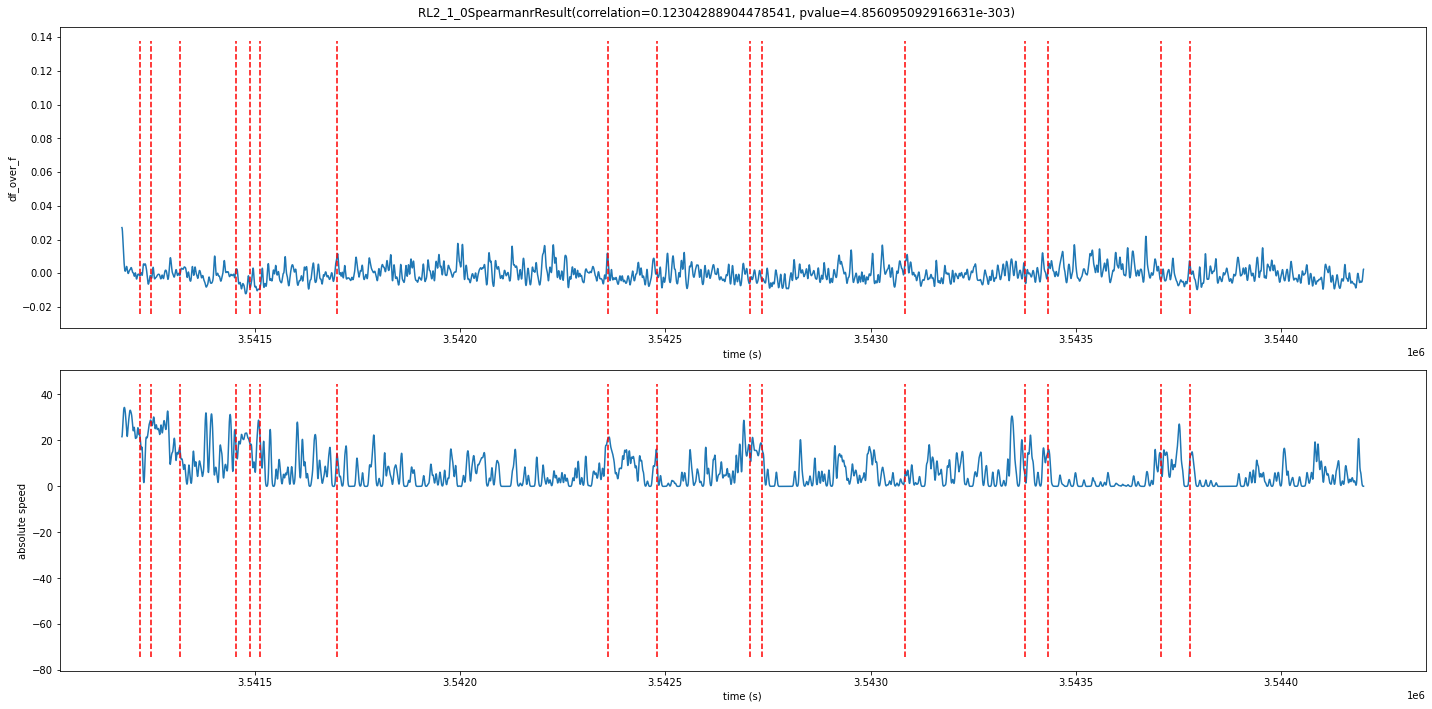

RL2_5_0
[  966  3248  3974  4458  7456  7598  8703 10725 11490 11710 12364 17924
 18875 22892 23325 25638 26372 30260 30550 35606 35887 37513 43547 43762
 47882 48286 51589 51764 52930 58273 61594 61914 67767 67930 69199 69722
 74806 75051]


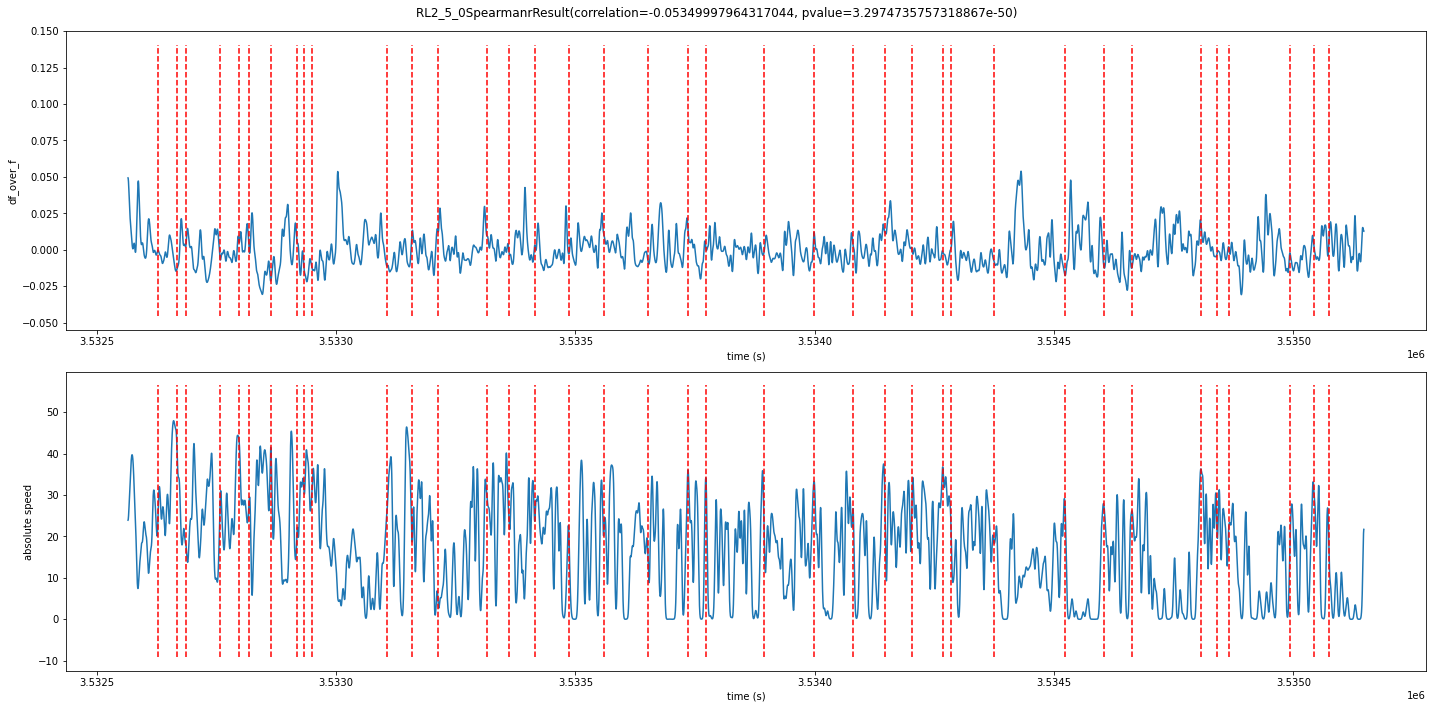

In [27]:
sessions_uid = ['RL2_1_0','RL2_5_0']

list_df_data = []
for uid in sessions_uid :
    print(uid)
    gain_change_df = format_data_psth(uid,plot_sessions=True,gain_change_sample="RL2_gain")
    list_df_data.append(gain_change_df)

gain_change_df = pd.concat(list_df_data)
gain_change_df = gain_change_df.dropna()
dict_map_mag = {-2.7 : "--", -2 : '-',-0.7:'-',0:'0',0.7 : '+',2.7 : "++", 2 : '+'}
gain_change_df['gain_change'] = gain_change_df['gain_change_magnitude'] 
gain_change_df = gain_change_df.replace({"gain_change_magnitude": dict_map_mag})

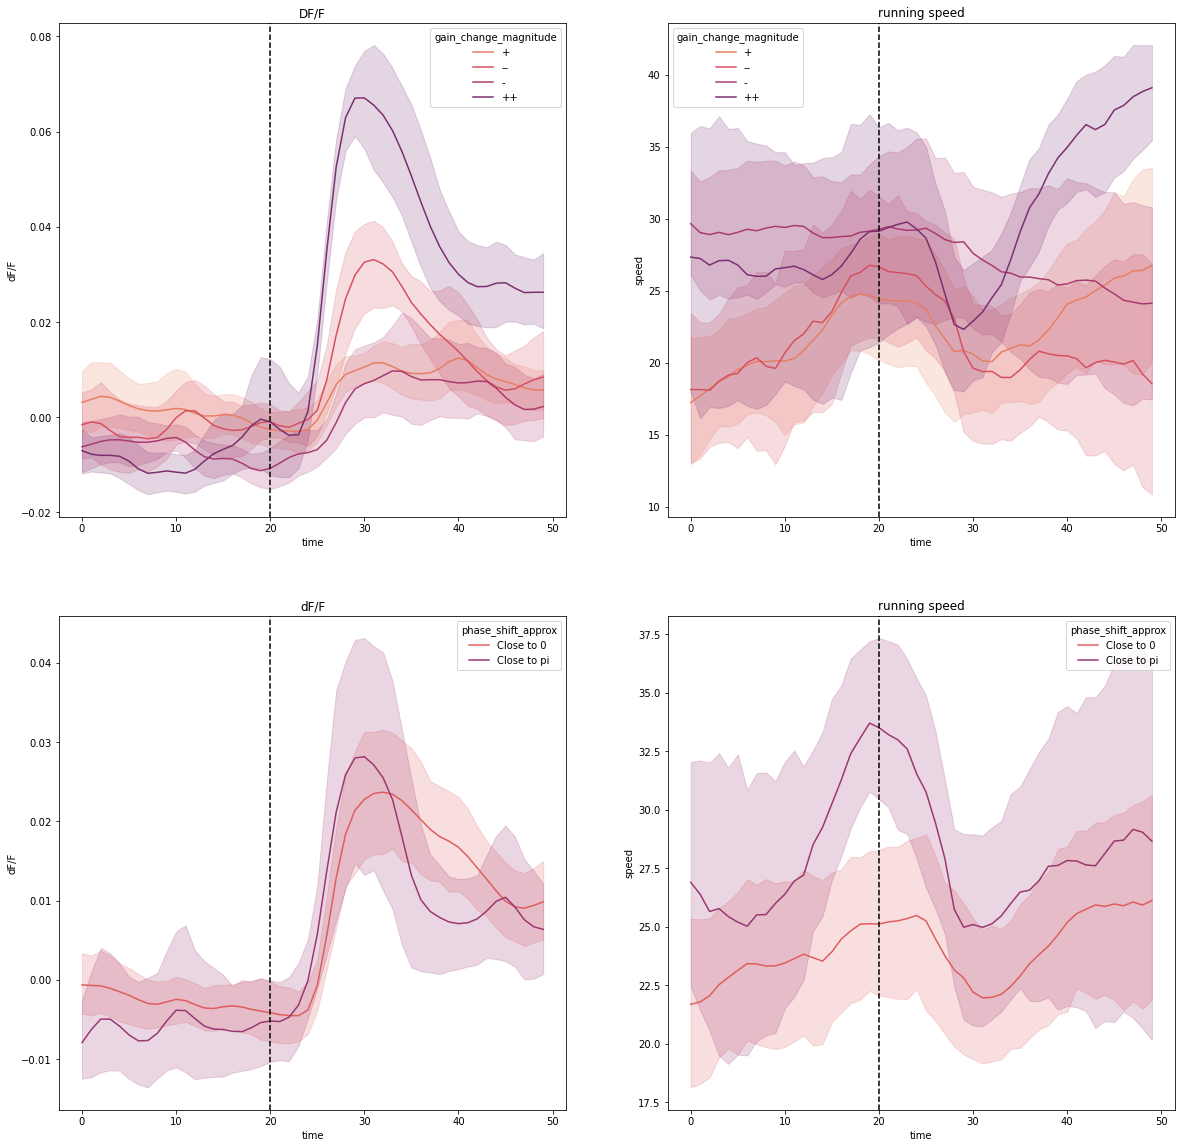

In [28]:
plt.figure(figsize=(20,20))


p_norm = 0.05

plt.subplot(221)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('DF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')


p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(['--','++']))]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['gain_change_magnitude'].isin(["0"]))]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")



plt.subplot(222)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='gain_change_magnitude',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')



plt.subplot(223)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="dF/F",
    hue='phase_shift_approx',
    palette="flare",
).set_title('dF/F')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

p_val = []
for i in range(nb_resample_points):
    a = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to 0")]['dF/F'].values
    b = gain_change_df[(gain_change_df['time'] == i) & (gain_change_df['phase_shift_approx'] == "Close to pi")]['dF/F'].values
    p_val.append(scipy.stats.ttest_ind(a,b).pvalue)

p_val_mask = np.array(p_val) < p_norm
p_val = np.array(p_val)[p_val_mask]*0 +0.01
x_axis_pval = np.arange(nb_resample_points)[p_val_mask]
plt.scatter(x_axis_pval,p_val,color='k',marker="+")

plt.subplot(224)
sns.lineplot(
    data=gain_change_df,
    x="time",
    y="speed",
    hue='phase_shift_approx',
    palette="flare",
).set_title('running speed')
x_zero =  int(time_pre/(time_pre+time_post)*nb_resample_points)
plt.axvline(x=x_zero,color='k',ls='--')

plt.show()